In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import os

import cppyy.ll
cppyy.ll.set_signals_as_exception(True)

import pandas as pd
import matplotlib.pyplot as plt

import g4ppyy as g4
from g4ppyy import new, G4ThreeVector
from g4ppyy.SI import mm, cm, m, eV, MeV, GeV, twopi, deg
import random
twopi = 360. * deg;

gRunManager = g4.G4RunManager()

[G4PPYY] : Geant4 Python wrapper for CPPYY
[G4PPYY] : author: P. Stowell
[G4PPYY] : Loading G4 Modules.
[G4PPYY] : G4PREFIX : /app/geant4-v11.2.2/install
[G4PPYY] : G4VERSION : 11.2.2
[G4PPYY] : Module loading complete.
Jupyter Magic : g4_k3d g4_compile
[G4PPYY] : Imported all definitions.

**************************************************************
 Geant4 version Name: geant4-11-02-patch-02 [MT]   (21-June-2024)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************



In [2]:
%%g4_compile
class PhotonTracker : public G4VSensitiveDetector {
  public:
  PhotonTracker(G4String name) : G4VSensitiveDetector(name) {
    neutron_event["eid"] = std::vector<double>();
    neutron_event["edep"] = std::vector<double>();
    neutron_event["x"] = std::vector<double>();
    neutron_event["y"] = std::vector<double>();
    neutron_event["z"] = std::vector<double>();

    columns.push_back("eid");
    columns.push_back("edep");
    columns.push_back("x");
    columns.push_back("y");
    columns.push_back("z");
  }

  void Reset(){
     count = 0;
  }
  G4bool ProcessHits(G4Step *aStep, G4TouchableHistory *ROhist){
    auto pdg = (aStep->GetTrack()->GetParticleDefinition()->GetPDGEncoding());
    if (pdg != -22 && pdg != 0){ return false; }
    count += 1;

    auto eid = 0; // #int(gRunManager.GetCurrentEvent().GetEventID())

    
    auto pos = aStep->GetPreStepPoint()->GetPosition();
    if (fabs(pos.z()) > 50) return false;

    neutron_event["eid"].push_back( eid );

    neutron_event["edep"].push_back(aStep->GetTotalEnergyDeposit());
    neutron_event["x"].push_back(pos.x());
    neutron_event["y"].push_back(pos.y());
    neutron_event["z"].push_back(pos.z());
    
    aStep->GetTrack()->SetTrackStatus(fStopAndKill);
    return true;
  };
  int count = 0;

  std::map<std::string, std::vector<double>> neutron_event;
  std::vector<std::string> columns;

};

In [3]:

class custom_neutron_tacker(g4.G4VSensitiveDetector):
    def Reset(self):
        self.neutron_event = {
            "eid": [],
            "edep": [],
            "x": [],
            "y": [],
            "z": []        
        }
        self.pdglist = []
                
    def ProcessHits(self, aStep, ROhist):
        
        pdg = (aStep.GetTrack().GetParticleDefinition().GetPDGEncoding())             
        if not (pdg == -22 or pdg == 0): return 0
            
        eid = int(gRunManager.GetCurrentEvent().GetEventID())

        self.neutron_event["eid"].append( eid )
        
        pos = aStep.GetPreStepPoint().GetPosition() 
        dirs = aStep.GetTrack().GetMomentumDirection() 
        ek = aStep.GetPreStepPoint().GetTotalEnergy() 

        self.neutron_event["edep"].append(aStep.GetTotalEnergyDeposit())
        self.neutron_event["x"].append(pos.x())
        self.neutron_event["y"].append(pos.y())
        self.neutron_event["z"].append(pos.z())
        
        aStep.GetTrack().SetTrackStatus(g4.G4TrackStatus.fStopAndKill)

        return 1

    def StartOfRunAction(self):
        self.Reset()

    def EndOfRunAction(self):
        self.df = pd.DataFrame(data=self.neutron_event)

    def VisualizationAction(self):
        
        plt.scatter(self.df.x, self.df.y, c=self.df.edep)
        plt.title(str(self.GetName()) + " : XY Edep")
        plt.xlabel("x [mm]")
        plt.ylabel("z [mm]")
        plt.show()
        
        plt.scatter(self.df.x, self.df.z, c=self.df.edep)
        plt.title(str(self.GetName()) + " : XZ Edep")
        plt.xlabel("x [mm]")
        plt.xlabel("z [mm]")
        plt.show()



# In[3]:
#obj = custom_neutron_tacker("test")
#obj = PhotonTracker()

import numpy as np
nm = 1.267

def nmtoev(x):
    h=4.1357e-15 #eVs 
    c=299792458  #ms-1
    x = np.array(x)*1e-9
    val = (h*c/x)*mm #in units of m
    return list(val*1e-6) #default units of mm

# list.nmtoev = nmtoev
# np.array.nmtoev = nmtoev

class custom_world(g4.cppyy.gbl.G4VUserDetectorConstruction):         
    def BuildMaterials(self):
        # Material definitions
        self.water_mat = g4.gNistManager.FindOrBuildMaterial("G4_WATER")        
        self.air_mat = g4.gNistManager.FindOrBuildMaterial("G4_AIR")
        
        self.loaded_water = g4.builder.build_material("LoadedWater",
                                                      density=1*g4.g/g4.cm3,
                                                      materials=["G4_WATER","G4_GADOLINIUM_OXYSULFIDE"],
                                                      fractions=[0.998,0.002],
                                                      RINDEX_X=nmtoev([100,500,600]),
                                                      RINDEX_Y=[1.2,1.2,1.2],
                                                      ABSLENGTH_X=nmtoev([100,500,600]),
                                                      ABSLENGTH_Y=[2.0*m, 2.0*m, 2.0*m],
                                                      RAYLEIGH_X=nmtoev([100,500,600]),
                                                      RAYLEIGH_Y=[10.0*m,10.0*m,10.0*m])
        
        self.loaded_water.GetMaterialPropertiesTable().DumpTable()
                                                      

    def BuildWorld(self):
        # Mother Box
        self.world = g4.builder.build_component("world", solid="box", 
                                                x=4*m, y=4*m, z=2*m, 
                                                material=self.air_mat)

        # World Geometries        
        self.hdpe_outer   = g4.builder.build_component("shell", 
                                                       solid="tubs", 
                                                       rot=[90*deg, 0.0, 0.0], 
                                                       rmax=11*cm, z=0.6*m/2, 
                                                       mother=self.world, 
                                                       material="G4_POLYETHYLENE", 
                                                       color=[0.0,0.0,1.0,0.8], 
                                                       drawstyle="solid")
        
        self.water_inner  = g4.builder.build_component("water", solid="tubs", 
                                                       rmax=9*cm, z=0.6*m/2, 
                                                       mother=self.hdpe_outer, 
                                                       material=self.loaded_water, 
                                                       color=[0.5,0.5,1.0,0.1], 
                                                       drawstyle="solid")

        pos_scale = +1
        self.hdpe_endcap1 = g4.builder.build_component("cap1", solid="tubs", rmax=9*cm, 
                                                       z=1*cm, 
                                                       mother=self.water_inner, 
                                                       material="G4_POLYETHYLENE", 
                                                       color=[1.0,0.2,1.0,0.8], 
                                                       drawstyle="solid", 
                                                       pos=[0.0, 0.0, pos_scale*(+0.6*m/2 - 1*cm)])
        
        self.hdpe_endcap1_hollow = g4.builder.build_component("cap1_hollow", solid="tubs", rmax=2.5*cm, 
                                                       z=1*cm, 
                                                       mother=self.hdpe_endcap1, 
                                                       material="G4_AIR", 
                                                       color=[1.0,0.2,1.0,0.8], 
                                                       drawstyle="solid", 
                                                       pos=[0.0, 0.0, 0.0])
        
        self.hdpe_endcap1_frontring = g4.builder.build_component("cap1_frontring", solid="tubs", rmax=5*cm, 
                                                       z=1*cm,  
                                                       mother=self.water_inner, 
                                                       material="G4_POLYETHYLENE", 
                                                       color=[1.0,0.2,1.0,0.8], 
                                                       drawstyle="solid", 
                                                       pos=[0.0, 0.0, pos_scale*(+0.6*m/2-3*cm)])

        self.hdpe_endcap1_fronthollow = g4.builder.build_component("cap1_fronthollow", solid="tubs", rmax=2.5*cm, 
                                                       z=1*cm, 
                                                       mother=self.hdpe_endcap1_frontring, 
                                                       material="G4_AIR", 
                                                       color=[1.0,0.2,1.0,0.8], 
                                                       drawstyle="solid", 
                                                       pos=[0.0, 0.0, 0.0])
        
        self.hdpe_endcap1_outerring = g4.builder.build_component("cap1_outerring", solid="tubs", rmax=5*cm, 
                                                       z=1*cm, rot=[90*deg, 0.0, 0.0], 
                                                       mother=self.world, 
                                                       material="G4_POLYETHYLENE", 
                                                       color=[1.0,0.2,1.0,0.8], 
                                                       drawstyle="solid", 
                                                       pos=[0.0,pos_scale*(+0.6*m/2+1*cm),0.0])
        
        self.hdpe_endcap1_outerhollow = g4.builder.build_component("cap1_outerhollow", solid="tubs", rmax=2.5*cm, 
                                                       z=1*cm, 
                                                       mother=self.hdpe_endcap1_outerring, 
                                                       material="G4_AIR", 
                                                       color=[1.0,0.2,1.0,0.8], 
                                                       drawstyle="solid", 
                                                       pos=[0.0, 0.0, 0.0])

        pos_scale = -1
        self.hdpe_endcap2 = g4.builder.build_component("cap2", solid="tubs", rmax=9*cm, 
                                                       z=1*cm, 
                                                       mother=self.water_inner, 
                                                       material="G4_POLYETHYLENE", 
                                                       color=[1.0,0.2,1.0,0.8], 
                                                       drawstyle="solid", 
                                                       pos=[0.0, 0.0, pos_scale*(+0.6*m/2 - 1*cm)])
        
        self.hdpe_endcap2_hollow = g4.builder.build_component("cap2_hollow", solid="tubs", rmax=2.5*cm, 
                                                       z=1*cm, 
                                                       mother=self.hdpe_endcap2, 
                                                       material="G4_AIR", 
                                                       color=[1.0,0.2,1.0,0.8], 
                                                       drawstyle="solid", 
                                                       pos=[0.0, 0.0, 0.0])
        
        self.hdpe_endcap2_frontring = g4.builder.build_component("cap2_frontring", solid="tubs", rmax=5*cm, 
                                                       z=1*cm, 
                                                       mother=self.water_inner, 
                                                       material="G4_POLYETHYLENE", 
                                                       color=[1.0,0.2,1.0,0.8], 
                                                       drawstyle="solid", 
                                                       pos=[0.0, 0.0, pos_scale*(+0.6*m/2-3*cm)])

        self.hdpe_endcap2_fronthollow = g4.builder.build_component("cap2_fronthollow", solid="tubs", rmax=2.5*cm, 
                                                       z=1*cm, 
                                                       mother=self.hdpe_endcap2_frontring, 
                                                       material="G4_AIR", 
                                                       color=[1.0,0.2,1.0,0.8], 
                                                       drawstyle="solid", 
                                                       pos=[0.0, 0.0, 0.0])
        
        self.hdpe_endcap2_outerring = g4.builder.build_component("cap2_outerring", solid="tubs", rmax=5*cm, 
                                                       z=1*cm, rot=[90*deg, 0.0, 0.0], 
                                                       mother=self.world, 
                                                       material="G4_POLYETHYLENE", 
                                                       color=[1.0,0.2,1.0,0.8], 
                                                       drawstyle="solid", 
                                                       pos=[0.0,pos_scale*(+0.6*m/2+1*cm),0.0])
        
        self.hdpe_endcap2_outerhollow = g4.builder.build_component("cap2_outerhollow", solid="tubs", rmax=2.5*cm, 
                                                       z=1*cm, 
                                                       mother=self.hdpe_endcap2_outerring, 
                                                       material="G4_AIR", 
                                                       color=[1.0,0.2,1.0,0.8], 
                                                       drawstyle="solid", 
                                                       pos=[0.0, 0.0, 0.0])

        self.lead_inner = g4.builder.build_component("lead_inner", solid="box", x=5*cm, y=5*cm, z=5*cm,
                                                       mother=self.water_inner, 
                                                       material="G4_Pb", 
                                                       color=[1.0,1.0,1.0,0.8], 
                                                       drawstyle="solid", 
                                                       pos=[0.0, 0.0, 0.0])

        # Build the PMTs
        pmt_con = new(g4.G4Cons("PMTGlass1",0, 2.5*cm, 0, 130*mm/2, 46*mm/2, 0, twopi))
        pmt_front = new(g4.G4Tubs("PMTGlass2", 0, 130*mm/2, 32*mm/2, 0, twopi))
        pmt_base = new(g4.G4Tubs("PMTGlass3", 0, 2.5*cm, 50*mm/2, 0, twopi))
        pmt_union = new(g4.G4UnionSolid("PMTGlass4", pmt_con, pmt_front, 0, G4ThreeVector(0,0,+46*mm/2+32*mm/2-0*mm)))
        pmt_union2 = new(g4.G4UnionSolid("PMTGlass5", pmt_union, pmt_base, 0, G4ThreeVector(0,0,-46*mm/2-50*mm/2+0*mm)))

        vac_con = new(g4.G4Cons("PMTVac1",0, 2.5*cm-1*mm, 0, 130*mm/2-1*mm, 46*mm/2-1*mm, 0, twopi))
        vac_front = new(g4.G4Tubs("PMTVac2", 0, 130*mm/2-1*mm, 32*mm/2-1*mm, 0, twopi))
        vac_base = new(g4.G4Tubs("PMTVac3", 0, 2.5*cm-1*mm, 50*mm/2-1*mm, 0, twopi))
        vac_union = new(g4.G4UnionSolid("PMTVac4", vac_con, vac_front, 0, G4ThreeVector(0,0,+46*mm/2+32*mm/2-0*mm)))
        vac_union2 = new(g4.G4UnionSolid("PMTVac5", vac_union, vac_base, 0, G4ThreeVector(0,0,-46*mm/2-50*mm/2+0*mm)))
        
        self.pmt1 = g4.builder.build_component("pmt1", solid=pmt_union2, 
                                               mother=self.water_inner, 
                                               material="G4_GLASS_PLATE", 
                                               color=[0.0,1.0,0.2,1.0], 
                                               drawstyle="solid", 
                                               pos=[0.0, 0.0, -0.6*m/2+50*mm+46*mm/2])

        self.vac1 = g4.builder.build_component("pmt1", solid=vac_union2, 
                                               mother=self.pmt1, 
                                               material="G4_AIR", 
                                               color=[0.0,0.0,0.2,0.5], 
                                               drawstyle="solid", 
                                               pos=[0.0, 0.0, 0.0])

        self.pcathode1 = g4.builder.build_component("pcathode1", solid="tubs",
                                               rmax=128*mm/2, z=0.01*mm,
                                               mother=self.pmt1, 
                                               material="G4_GLASS_PLATE", 
                                               color=[1.0,0.0,0.0,1.0], 
                                               drawstyle="solid", 
                                               pos=[0.0, 0.0, (46/2+32)*mm-0.01*mm/2])

        self.pmt2 = g4.builder.build_component("pmt2", solid=pmt_union2, 
                                               mother=self.water_inner, 
                                               rot=[180*g4.deg,0.0,0.0],
                                               material="G4_GLASS_PLATE", 
                                               color=[0.0,1.0,0.2,1.0], 
                                               drawstyle="solid", 
                                               pos=[0.0, 0.0, +0.6*m/2-50*mm-46*mm/2])

        self.vac2 = g4.builder.build_component("pmt1", solid=vac_union2, 
                                               mother=self.pmt2, 
                                               material="G4_AIR", 
                                               color=[0.0,0.0,0.2,0.5], 
                                               drawstyle="solid", 
                                               pos=[0.0, 0.0, 0.0])

        self.pcathode2 = g4.builder.build_component("pcathode2", solid="tubs",
                                               rmax=128*mm/2, z=0.01*mm,
                                               mother=self.pmt2, 
                                               material="G4_GLASS_PLATE", 
                                               color=[1.0,0.0,0.0,1.0], 
                                               drawstyle="solid", 
                                               pos=[0.0, 0.0, (46/2+32)*mm-0.01*mm/2])
        
        
    def BuildDetectors(self):
        self.ptdet = g4.PhotonTracker("ptdet")
        # self.ptdet = custom_neutron_tacker("ptdet")
        self.water_inner .GetLogicalVolume().SetSensitiveDetector(self.ptdet)
        g4.run.register_detector_hooks(self.ptdet)
        
    def Construct(self):
        self.BuildMaterials()
        self.BuildWorld()
        self.BuildDetectors()        
        return self.world # top mother volume


# In[4]:


class custom_generator(g4.G4VUserPrimaryGeneratorAction):
    "Flat Energy Spectrum Upward Neutron Generator"
    def __init__(self):
        super().__init__()
        self.particle = g4.G4Neutron.Definition()
        self.particleGun = g4.G4ParticleGun()
        self.particleGun.SetParticleDefinition(self.particle)
        self.particleGun.SetParticleMomentumDirection(g4.G4ThreeVector(0, 0, -1))
        self.particleGun.SetParticlePosition(g4.G4ThreeVector(0.0,0.0,+20.0*cm))
        self.particleGun.SetNumberOfParticles(1)  
        self.particleGun.SetParticleTime(0)

    def GeneratePrimaries(self, anEvent):
        print("GEN MUON")
        energy = random.random() * 200 * MeV
        self.particleGun.SetParticleEnergy(energy)  
        self.particleGun.GeneratePrimaryVertex(anEvent)

physics = g4.QGSP_BERT()
op = g4.G4OpticalPhysics()
opticalPhysics = g4.G4OpticalPhysics()
opticalParams = g4.G4OpticalParameters.Instance()
opticalParams.SetBoundaryInvokeSD(True);
# opticalParams.SetCerenkovMaxPhotonsPerStep(100)
# opticalParams.SetCerenkovStackPhotons(1)
physics.RegisterPhysics(op)
gRunManager.SetUserInitialization(physics)

# Add a World
detector = g4.new(custom_world())
gRunManager.SetUserInitialization(detector)

# Add a Generator
gen = g4.new(g4.PrimaryGeneratorAction("", 0.25*m))

# gen = g4.new(custom_generator())
gRunManager.SetUserAction(gen)

# Add standard GEANT4 Actions
g4.run.add_default_actions(gRunManager)

# Setup vis to check geometry (optioonal)
# g4.run.create_visualization(gRunManager)

gRunManager.Initialize()

# g4.mc.vis.scene.add.trajectories("rich")

# traj_mc = g4.mc.vis.modeling.trajectories
# traj_mc.create.drawByParticleID()
# traj_mc.drawByParticleID_0.default.setDrawStepPts(True)
# traj_mc.drawByParticleID_0.default.setStepPtsSize(1)
# traj_mc.drawByParticleID_0.set("e+","white")
# traj_mc.drawByParticleID_0.set("e-","white")
# traj_mc.drawByParticleID_0.set("gamma","yellow")
# traj_mc.drawByParticleID_0.set("neutron","magenta")
# traj_mc.drawByParticleID_0.set("proton","blue")
# traj_mc.drawByParticleID_0.set("pi+","red")
# traj_mc.drawByParticleID_0.set("pi-","red")
# traj_mc.drawByParticleID_0.set("pi0","grey")
# traj_mc.drawByParticleID_0.set("mu-","red")
# traj_mc.drawByParticleID_0.set("mu+","red")
# traj_mc.drawByParticleID_0.set("opticalphoton","white")
# traj_mc.drawByParticleID_0.set("optical_photon","white")

g4.mc.CRY.input("returnNeutrons 1")
g4.mc.CRY.input("returnProtons 1")
g4.mc.CRY.input("returnMuons 1")
g4.mc.CRY.input("returnGammas 1")
g4.mc.CRY.input("returnPions 1")
g4.mc.CRY.input("returnKaons 1")
g4.mc.CRY.input("date 7-1-2012")
g4.mc.CRY.input("latitude 90.0")
g4.mc.CRY.input("altitude 0")
g4.mc.CRY.input("subboxLength 1")
g4.mc.CRY.update()

<<< Geant4 Physics List simulation engine: QGSP_BERT

0: RINDEX
2.06642e-06   1.2
2.4797e-06   1.2
1.23985e-05   1.2
9: GROUPVEL
2.06642e-06   249.827
2.27306e-06   249.827
1.23985e-05   249.827
11: RAYLEIGH
2.06642e-06   10000
2.4797e-06   10000
1.23985e-05   10000
16: ABSLENGTH
2.06642e-06   2000
2.4797e-06   2000
1.23985e-05   2000

 hInelastic QGSP_BERT  Thresholds: 
    1) between BERT  and FTF/P over the interval 3 to 6 GeV. 
    2) between FTF/P and QGS/P over the interval 12 to 25 GeV. 
  -- quasiElastic: 1 for QGS  and 0 for FTF
### Adding tracking cuts for neutron  TimeCut(ns)= 10000  KinEnergyCut(MeV)= 0
### Birks coefficients used in run time
CRY::CRYSetup: Setting returnNeutrons to 1
CRY::CRYSetup: Setting returnProtons to 1
CRY::CRYSetup: Setting returnMuons to 1
CRY::CRYSetup: Setting returnGammas to 1
CRY::CRYSetup: Setting returnPions to 1
CRY::CRYSetup: Setting returnKaons to 1
CRY::CRYSetup: Setting date to 7-1-2012 (month-day-year)
CRY::CRYSetup: Setting latitude to

In [4]:
import time
tb = (time.time())
g4.run.handle_beam(gRunManager, 10000)
ta = time.time()
val = ((ta-tb)/10000)*1000
print(val,"ms")

2.1625934839248657 ms
======                 Electromagnetic Physics Parameters      ========
LPM effect enabled                                 1
Enable creation and use of sampling tables         0
Apply cuts on all EM processes                     0
Use combined TransportationWithMsc                 Disabled
Use general process                                1
Enable linear polarisation for gamma               0
Enable photoeffect sampling below K-shell          1
Enable sampling of quantum entanglement            0
X-section factor for integral approach             0.8
Min kinetic energy for tables                      100 eV 
Max kinetic energy for tables                      100 TeV
Number of bins per decade of a table               7
Verbose level                                      1
Verbose level for worker thread                    0
Bremsstrahlung energy threshold above which 
  primary e+- is added to the list of secondary    100 TeV
Bremsstrahlung energy threshold above w

In [5]:
import pandas as pd

data = {}
df = pd.DataFrame()
for i in range(detector.ptdet.columns.size()):
    c = detector.ptdet.columns[i]
    vals = detector.ptdet.neutron_event[c]
    data[c] = np.array(vals)
df = pd.DataFrame(data=data)

In [6]:
print(len(df))

4635489


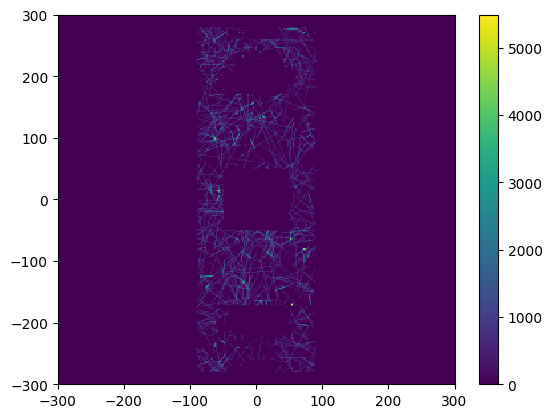

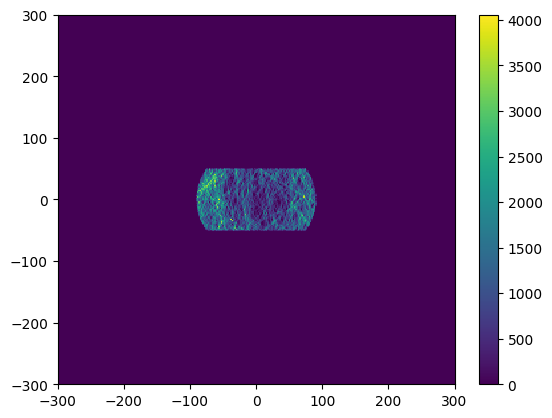

In [7]:
ndf = df[(df.z < 50)&(df.z>-50)]
plt.hist2d(ndf.x, ndf.y, bins=[np.linspace(-300,300,300),np.linspace(-300,300,300)])
plt.ylim([-300,300])
plt.xlim([-300,300])
plt.colorbar()
plt.show()

# plt.scatter(df.x, df.z, s=1)
plt.hist2d(ndf.x, ndf.z, bins=[np.linspace(-300,300,300),np.linspace(-300,300,300)])

plt.ylim([-300,300])
plt.xlim([-300,300])
plt.colorbar()
plt.show()

In [8]:
# df.columns